In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/data.zip" -d "."

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFile
from statistics import mean

import torch
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Constants
EPOCHS = 5
BATCH_SIZE = 32

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(f'Using {device}')

Using cuda


In [5]:
# Set seed during training for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

In [6]:
ID_TO_BREED = {}

for dog_folder in os.listdir('data/train'):
    dog_id, dog_name = dog_folder.split('.')
    dog_id = int(dog_id)-1
    
    ID_TO_BREED[dog_id] = dog_name

In [7]:
class DogDataset(Dataset):
    def __init__(self, folder, transform = None):
        self.images_path = []
        self.labels = []
        
        self.transform = transform
        
        for dog_folder in os.listdir(os.path.join('data',folder)):
            dog_id, _ = dog_folder.split('.')
            
            dog_id = int(dog_id)-1
            
            for dog_file in os.listdir(os.path.join('data',folder,dog_folder)):
                file_path = os.path.join('data',folder,dog_folder,dog_file)
                
                self.images_path.append(file_path)
                self.labels.append(dog_id)
        
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, idx):
        image = Image.open(self.images_path[idx]).convert('RGB')
        
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label
    
def my_collator(batch):
    """
    In: O lista, in care fiecare element e un tuple ce contine imaginea+label
    list[tuple()] -> no_of_batches x 2, (2 = image + label)
    Out: 2 tensori, unul cu imaginile, unul cu labelurile
    """
    batch_size = len(batch)
    image_size = batch[0][0].shape
    
    images = torch.zeros((batch_size,*image_size))
    labels = torch.zeros(batch_size)
    
    for i in range(len(batch)):
        images[i] = batch[i][0]
        labels[i] = batch[i][1]
        
    return images,labels

In [8]:
# Create datasets and dataloaders
transforms_augmented = T.Compose([
    T.Resize((224,224)),
    T.CenterCrop((224,224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    # T.ColorJitter(brightness=0.5, hue=0.3),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Training
train_dataset = DogDataset('train', transform=transforms_augmented)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=my_collator, shuffle=True)

# Validation
valid_dataset = DogDataset('valid', transform=transforms)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=my_collator)

# Testing
test_dataset = DogDataset('test', transform=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=my_collator)

# _ = next(train_dataloader.__iter__())  # images: torch.Size([4, 3, 224, 224]), labels

In [9]:
class CustomResnet(torch.nn.Module):
    def __init__(self, no_classes, device):
        super().__init__()
        
        self.model = resnet50(pretrained=True)
        
        no_in_ftrs_fc = self.model.fc.in_features
        
        self.model.fc = torch.nn.Linear(in_features=no_in_ftrs_fc, out_features=no_classes)
        
        self.device = device
        # self.model.to(device=device)

        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.fc.parameters(), lr=0.001)
        
    def forward(self, x):
        return self.model(x)

    def calculate_loss(self, preds, target):
        return self.criterion(preds, target)

    def back_propagate(self, loss): 
        self.optimizer.zero_grad()
        
        loss.backward()
        
        self.optimizer.step()

    def predict(self, image):
        image = image.unsqueeze(0)
        self.model.eval()
        
        with torch.no_grad():
            pred = self.model(image)
            return int(torch.argmax(pred).item())
        
    def evaluate(self, dataloader):
        self.model.eval()
        
        losses = []
        total = 0
        correct = 0
        
        with torch.no_grad():
            for step, (images,labels) in enumerate(dataloader):
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.long)
                
                logits = self.forward(images)
                loss = self.calculate_loss(logits, labels)
                
                preds = torch.argmax(logits, 1)
                correct += (torch.sum(preds == labels)).item()
                total += len(labels)
                
                losses.append(loss.item())
                
        accuracy = round(100 * correct / total, 2)
                
        return round(mean(losses),3), accuracy
        
    def train(self): 
        self.model.train()
        
    def eval(self):
        self.model.eval()

In [10]:
model = CustomResnet(no_classes=len(ID_TO_BREED), device=device)
model = model.to(device=device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
losses = []
print('Start training')
for epoch in range(EPOCHS):
    for step, (images,labels) in enumerate(train_dataloader):
        model.train()
        
        images = images.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)

        logits = model.forward(images)
        loss = model.calculate_loss(logits, labels)
        model.back_propagate(loss)

        print(f'\rEpoch {epoch:<2} / Step {step:<3}: training_loss = {loss.item(): <4}', end='')
        if step % 50 == 0:
            model.eval()
            valid_loss, valid_accuracy = model.evaluate(valid_dataloader)
            
            print(f'\n\rEpoch {epoch:<2} / Step {step:<3}: acc = {valid_accuracy:>2}% loss = {valid_loss: <4}')
            
            losses.append((loss.item(), valid_loss))

Start training
Epoch 0  / Step 0  : training_loss = 4.908907413482666
Epoch 0  / Step 0  : acc = 2.04% loss = 5.181
Epoch 0  / Step 50 : training_loss = 2.850318670272827
Epoch 0  / Step 50 : acc = 48.38% loss = 2.536
Epoch 0  / Step 100: training_loss = 1.7367615699768066
Epoch 0  / Step 100: acc = 63.95% loss = 1.591
Epoch 0  / Step 150: training_loss = 1.2850407361984253
Epoch 0  / Step 150: acc = 71.98% loss = 1.11
Epoch 0  / Step 200: training_loss = 0.9839314222335815
Epoch 0  / Step 200: acc = 74.49% loss = 0.98
Epoch 1  / Step 0  : training_loss = 0.6657920479774475
Epoch 1  / Step 0  : acc = 75.81% loss = 0.946
Epoch 1  / Step 50 : training_loss = 0.49924740195274353
Epoch 1  / Step 50 : acc = 76.77% loss = 0.867
Epoch 1  / Step 100: training_loss = 0.79439377784729
Epoch 1  / Step 100: acc = 76.53% loss = 0.845
Epoch 1  / Step 150: training_loss = 0.5041460394859314
Epoch 1  / Step 150: acc = 77.96% loss = 0.771
Epoch 1  / Step 200: training_loss = 0.6319040060043335
Epoch 1 

In [13]:
test_loss, test_accuracy = model.evaluate(test_dataloader)
            
print(f'acc = {test_accuracy:>2}% loss = {test_loss: <4}')

acc = 81.7% loss = 0.599


In [16]:
img,lab = test_dataset[52]

img = img.to(device=device)

pred = model.predict(img)
print(f'pred={pred}, label={lab}')

pred=60, label=60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


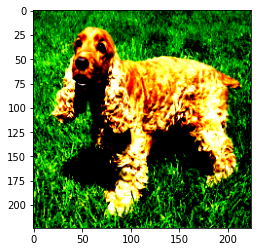

In [15]:
image, label = test_dataset[52]

plt.imshow(torch.permute(image, (1,2,0)))
plt.show()